In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor

# Load the full datasets
train_features = pd.read_csv('data/train_features_original.csv', header=0)
train_labels = pd.read_csv('data/train_labels.csv', header=0).values.ravel()
val_features = pd.read_csv('data/val_features_original.csv', header=0)
val_labels = pd.read_csv('data/val_labels.csv', header=0).values.ravel()
test_features = pd.read_csv('data/test_features_original.csv', header=0)
test_labels = pd.read_csv('data/test_labels.csv', header=0).values.ravel()

# Define the features to keep based on permutation importance (top 8)
important_features = [
    'icm_temp', 'oh_temp_clean', 'fps_density', 'icm_rh', 'fps_temp',
    'fps_dielectric', 'fps_vcst', 'fps_v'
]

# Select only the important features from the datasets
train_features = train_features[important_features]
val_features = val_features[important_features]
test_features = test_features[important_features]

# Scale features using StandardScaler
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
val_features_scaled = scaler.transform(val_features)
test_features_scaled = scaler.transform(test_features)

# Function to create the neural network model
def create_model(hidden_layers=1, units=50, learning_rate=0.001, activation='relu'):
    model = Sequential()
    model.add(Dense(units, input_dim=train_features_scaled.shape[1], activation=activation))  
    for _ in range(hidden_layers - 1):
        model.add(Dense(units, activation=activation))
    model.add(Dense(1))  
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mse'])
    return model

# Wrapping Keras model to use with scikit-learn's GridSearchCV
model = KerasRegressor(
    model=create_model,  
    epochs=30,
    batch_size=32,
    verbose=1
)

# Define parameter grid for GridSearchCV
param_grid = {
    'model__hidden_layers': [1, 2],          
    'model__units': [50, 100],               
    'model__learning_rate': [0.001, 0.01],   
    'model__activation': ['relu', 'tanh'],   
}

# Grid Search with cross-validation and parallelism
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(train_features_scaled, train_labels)  # Use scaled training data

# Select the best model and make predictions
best_model = grid_search.best_estimator_
val_predictions = best_model.predict(val_features_scaled)  
test_predictions = best_model.predict(test_features_scaled)  

# Function to display regression metrics
def print_regression_metrics(true_labels, predictions, dataset_name):
    mse = mean_squared_error(true_labels, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_labels, predictions)
    mape = mean_absolute_percentage_error(true_labels, predictions)
    r2 = r2_score(true_labels, predictions)
    
    print(f"\n{dataset_name} Metrics:")
    print(f"{'Metric':<30}{'Value':<10}")
    print(f"{'-'*40}")
    print(f"{'Mean Squared Error (MSE)':<30}{mse:.4f}")
    print(f"{'Root Mean Squared Error (RMSE)':<30}{rmse:.4f}")
    print(f"{'Mean Absolute Error (MAE)':<30}{mae:.4f}")
    print(f"{'Mean Absolute Percentage Error (MAPE)':<30}{mape:.4%}")
    print(f"{'R^2 Score':<30}{r2:.4f}")

# Print the best parameters from GridSearchCV
print(f'Best Parameters: {grid_search.best_params_}')

# Print metrics for validation and test sets
print_regression_metrics(val_labels, val_predictions, 'Validation')
print_regression_metrics(test_labels, test_predictions, 'Test')


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Epoch 1/30
4604/4604 [==============================] - 8s 2ms/step - loss: 0.1422 - mse: 0.1422
Epoch 2/30
4604/4604 [==============================] - 6s 1ms/step - loss: 0.0856 - mse: 0.0856
Epoch 3/30
4604/4604 [==============================] - 6s 1ms/step - loss: 0.0743 - mse: 0.0743
Epoch 4/30
4604/4604 [==============================] - 6s 1ms/step - loss: 0.0685 - mse: 0.0685
Epoch 5/30
4604/4604 [==============================] - 6s 1ms/step - loss: 0.0648 - mse: 0.0648
Epoch 6/30
4604/4604 [==============================] - 6s 1ms/step - loss: 0.0624 - mse: 0.0624
Epoch 7/30
4604/4604 [==============================] - 6s 1ms/step - loss: 0.0610 - mse: 0.0610
Epoch 8/30
4604/4604 [==============================] - 6s 1ms/step - loss: 0.0589 - mse: 0.0589
Epoch 9/30
4604/4604 [==============================] - 6s 1ms/step - loss: 0.0568 - mse: 0.0568
Epoch 10/30
4604/4604 [==============================] - 6s 1ms/st

1535/1535 [==============================] - 1s 929us/step


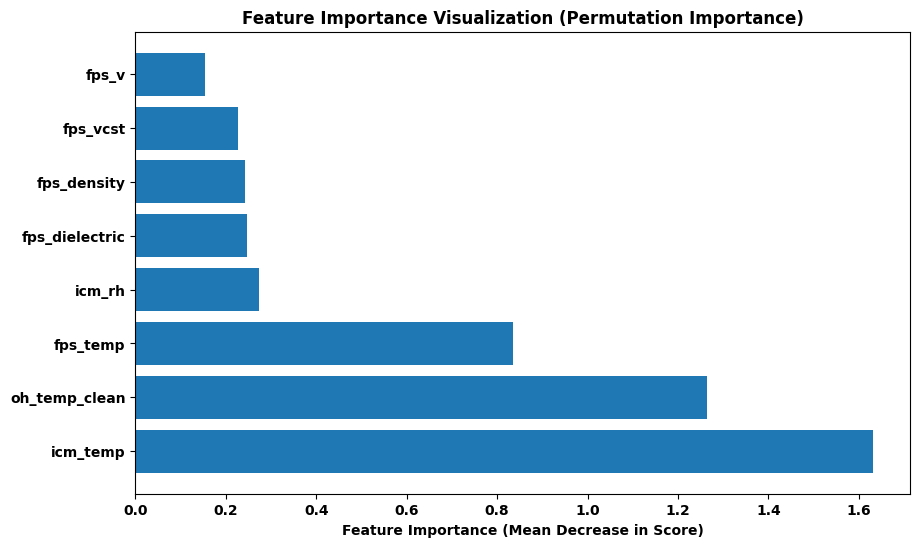

icm_temp                      : 1.6323
oh_temp_clean                 : 1.2652
fps_temp                      : 0.8348
icm_rh                        : 0.2729
fps_dielectric                : 0.2474
fps_density                   : 0.2427
fps_vcst                      : 0.2263
fps_v                         : 0.1532


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

best_model = grid_search.best_estimator_

# Permutation importance on the validation set
perm_importance = permutation_importance(best_model, val_features_scaled, val_labels, n_repeats=10, random_state=42)

# Get the mean importance scores
importance_mean = perm_importance.importances_mean

# Sort the feature importances in descending order
sorted_idx = importance_mean.argsort()

# Plotting the feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(importance_mean)), importance_mean[sorted_idx], align='center')
plt.yticks(range(len(importance_mean)), val_features.columns[sorted_idx])
plt.xlabel('Feature Importance (Mean Decrease in Score)')
plt.title('Feature Importance Visualization (Permutation Importance)')
plt.gca().invert_yaxis()  
plt.show()

for idx in sorted_idx[::-1]:  # Print from highest to lowest importance
    print(f"{val_features.columns[idx]:<30}: {importance_mean[idx]:.4f}")
